# Brief Overview of Network Data Science

Networks are extremely rich data structures which admit a wide variety of insightful data analysis tasks. In this set of notes, we'll consider two of the fundamental tasks in network data science: centrality and clustering. We'll also get a bit more practice with network visualization. 

In [4]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

We'll mostly stick with the Karate Club network for today, as this is a very good network for visualization. 

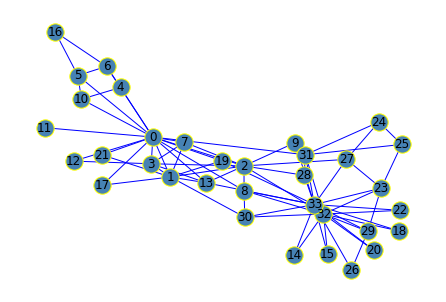

In [5]:
G = nx.karate_club_graph()
layout = nx.layout.fruchterman_reingold_layout(G)
nx.draw(G, 
        layout, 
        with_labels=True, 
        node_color = "steelblue",
        edgecolors = "yellow",
        edge_color = "blue")

### Centrality in Networks

Given a system, how can we determine *important* components in that system? In networks, the idea of importance is often cashed out in terms of *centrality*: important nodes are the nodes that are most "central" to the network. But how should we define or measure this? 

One good way is by computing the degree (i.e. the number of friends possessed by each node). 

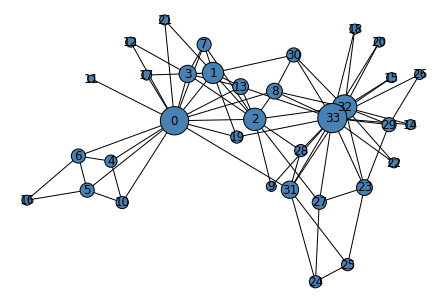

In [40]:
deg = G.degree()
nx.draw(G, layout,
        with_labels=True, 
        node_color = "steelblue",
        node_size  = [50*deg[i] for i in G.nodes()],
        edgecolors = "black")

The degree is a direct measure of popularity. But what if it matters not only *how many* friends you have, but *who* those friends are? Maybe we'd like to measure importance using the following, apparently circular idea: 

> Central nodes tend to be connected to other central nodes. 

As it turns out, one way to cash out this idea is in terms of...linear algebra! In particular, let's suppose that *my* importance should be proportional to the sum of the importances of my friends. So, if $v_i$ is the importance of node $i$, then we can write 

$$ v_i = \alpha\sum_{j \;\text{friends with} \;i} v_j\;, $$

where $\alpha$ is some constant of proportionality. Let's write this up a little more concisely. Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the *adjacency* matrix, with entries 

$$ a_{ij} = \begin{cases}1 &\quad i \;\text{is friends with} \;j \\ 0 &\quad \text{otherwise.}\end{cases}$$

Now, our equation above can be written in matrix-vector form as: 

$$\mathbf{v} = \alpha \mathbf{A} \mathbf{v}$$. 

Wait! This says that $\mathbf{v}$ is an eigenvector of $\mathbf{A}$ with eigenvalue $\frac{1}{\alpha}$! So, we can compute centralities by finding eigenvectors of $\mathbf{A}$. Usually, we just take the largest one (why?).

Answer:
Since the entries in the adjacency matrix are non-negative, there is a unique largest eigenvalue, which is real and positive, by the Perron–Frobenius theorem.

Let's try it out! Our first step is to obtain the adjacency matrix $\mathbf{A}$.  

In [4]:
# get adjancency matrix
nx.adjacency_matrix(G)

<34x34 sparse matrix of type '<class 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

In [5]:
nx.adjacency_matrix(G).todense()

matrix([[0, 1, 1, ..., 1, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0]])

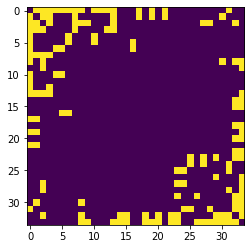

In [6]:
A = np.array(nx.adjacency_matrix(G).todense())
plt.imshow(A)

Now let's find the eigenvector corresponding to the largest eigenvalue. 

In [42]:
S,D = np.linalg.eigh(A)
print(S)
print(D)

[-4.48722919e+00 -3.44793486e+00 -3.11069092e+00 -2.43742443e+00
 -2.09082295e+00 -2.00000000e+00 -1.68768945e+00 -1.44407374e+00
 -1.19242425e+00 -1.04208785e+00 -7.92406815e-01 -4.18818748e-01
 -1.41161387e-15 -1.03172327e-15 -6.47894987e-16 -4.96393987e-16
 -3.32087949e-16  1.18282106e-16  4.22335646e-16  5.93393843e-16
  1.33608579e-15  1.83622556e-15  2.99410685e-01  4.19729474e-01
  6.15840589e-01  8.34304102e-01  1.03145042e+00  1.08328639e+00
  1.45305566e+00  1.48615954e+00  2.30908767e+00  2.91650670e+00
  4.97707423e+00  6.72569773e+00]
[[ 0.31716992 -0.27730159  0.55468453 ... -0.19785758  0.38686107
  -0.35549144]
 [ 0.12496128 -0.10787731  0.01703733 ...  0.25029731  0.26893952
  -0.26595992]
 [ 0.02726159  0.53924221  0.13327895 ...  0.2466749   0.13115956
  -0.3171925 ]
 ...
 [-0.26735819  0.18302254 -0.01093306 ... -0.14613828 -0.10223455
  -0.19103384]
 [ 0.281354   -0.33230442 -0.36967755 ... -0.03723557 -0.32455583
  -0.30864422]
 [ 0.52093712  0.32343689 -0.1354469

In [71]:
eig_centrality = D[:,-1]
eig_centrality

array([-0.35549144, -0.26595992, -0.3171925 , -0.21117972, -0.07596882,
       -0.07948305, -0.07948305, -0.17095975, -0.22740391, -0.10267425,
       -0.07596882, -0.0528557 , -0.08425463, -0.22647272, -0.10140326,
       -0.10140326, -0.02363563, -0.09239954, -0.10140326, -0.14791251,
       -0.10140326, -0.09239954, -0.10140326, -0.15011857, -0.05705244,
       -0.05920647, -0.07557941, -0.13347715, -0.13107782, -0.13496082,
       -0.1747583 , -0.19103384, -0.30864422, -0.37336347])

Now let's use this to create a plot: 

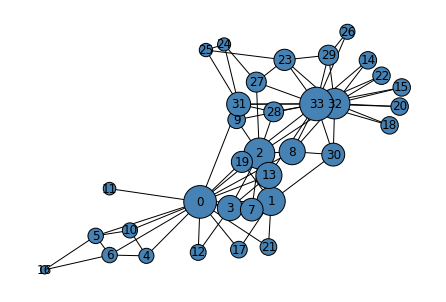

In [47]:
nx.draw(G, layout,
        with_labels=True, 
        node_color = "steelblue", 
        node_size  = 3000*eig_centrality,
        edgecolors = "black")

## PageRank

PageRank is an algorithm for finding important entities in a complex, relational system. In fact, it's a form of centrality! While we could obtain the adjacency matrix and do the linear algebra manipulations to compute PageRank, an easier way is to use one of the many centrality measures built in to NetworkX.

In [6]:
PR = nx.algorithms.link_analysis.pagerank_alg.pagerank(G)
PR

{0: 0.09700181758983706,
 1: 0.052878391037427,
 2: 0.05707842304763673,
 3: 0.035860643223064786,
 4: 0.021979406974834498,
 5: 0.02911334166344221,
 6: 0.029113341663442205,
 7: 0.02449075803950918,
 8: 0.029765339186167028,
 9: 0.014308950284462798,
 10: 0.021979406974834494,
 11: 0.009564916863537146,
 12: 0.014645186487916188,
 13: 0.02953631497720298,
 14: 0.014535161524273824,
 15: 0.014535161524273824,
 16: 0.016785378110253487,
 17: 0.01455885977424349,
 18: 0.014535161524273824,
 19: 0.01960441671193729,
 20: 0.014535161524273824,
 21: 0.01455885977424349,
 22: 0.014535161524273824,
 23: 0.03152091531163227,
 24: 0.021075455001162945,
 25: 0.02100562817474579,
 26: 0.015043395360629753,
 27: 0.025638803528350497,
 28: 0.019572960509438537,
 29: 0.026287262837112076,
 30: 0.024589336534292478,
 31: 0.037156635922679405,
 32: 0.07169213006588289,
 33: 0.1009179167487121}

*Yes, we could have done this for eigenvector centrality as well.* 

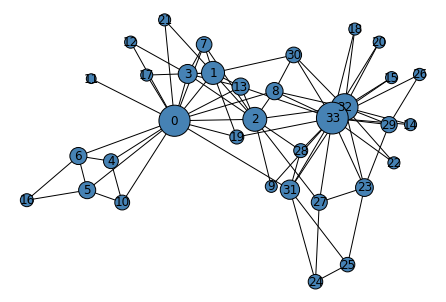

In [43]:
nx.draw(G, layout,
        with_labels=True, 
        node_color = "steelblue", 
        node_size  = [10000*PR[i] for i in G.nodes()],
        edgecolors = "black")

Different centrality measures have different mathematical definitions and properties, which means that appropriately interpreting a given measure can be somewhat tricky. One should be cautious before leaping to conclusions about "the most important node in the network." For example, the results look noticeably different when we use betweenness centrality, a popular heuristic that considers nodes to be more important if they are "between" lots of pairs of other nodes. 

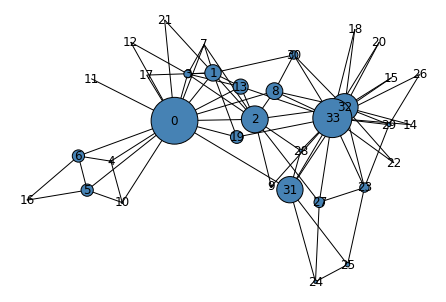

In [45]:
bc = nx.algorithms.centrality.betweenness_centrality(G)

nx.draw(G, layout,
        with_labels=True, 
        node_color = "steelblue", 
        node_size  = [5000*bc[i] for i in G.nodes()],
        edgecolors = "black")

## Graph Clustering

Graph clustering refers to the problem of finding collections of related nodes in the graph. It is one form of unsupervised machine learning, and is similar to problems that you may have seen like k-means and spectral clustering. Indeed, spectral clustering works well on graphs! 

As mentioned above, a common benchmark for graph clustering algorithms is to attempt to reproduce the observed division of the Karate Club graph. Recall that that looks like this: 

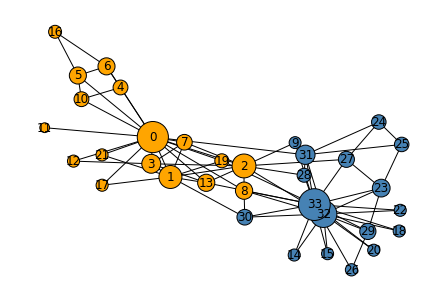

In [7]:
clubs = nx.get_node_attributes(G, "club")

nx.draw(G, layout,
        with_labels=True, 
        node_color = ["steelblue" if clubs[i] == "Officer" else "orange" for i in G.nodes()],
        node_size  = [10000*PR[i] for i in G.nodes()],
        edgecolors = "black")

The core idea of most clustering algorithms is that densely-connected sets of nodes are more likely to be members of the same cluster. There are *many* algorithms for graph clustering, which can lead to very different results. 

Here's one example. 

In [8]:
comms = nx.algorithms.community.label_propagation.label_propagation_communities(G)
comms = list(comms)
comms

[{0, 1, 3, 4, 7, 10, 11, 12, 13, 17, 19, 21, 24, 25, 31},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 33},
 {5, 6, 16}]

The variable `comms` is now a list of sets. Nodes in the same set are viewed as belonging to the same cluster. Let's visualize these: 

In [13]:
labels = {j : i for j in G.nodes() for i in range(len(comms)) if j in comms[i]}

color_possibilities = ["orange", "steelblue", "lavender"]
colors = [color_possibilities[labels[j]] for j in G.nodes]

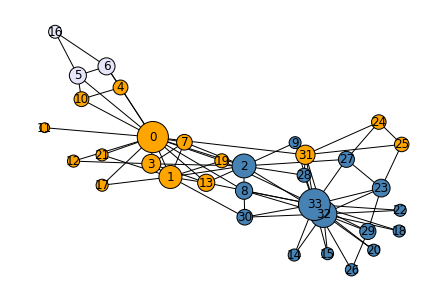

In [14]:
nx.draw(G, layout,
        with_labels=True, 
        node_color = colors,
        node_size  = [10000*PR[i] for i in G.nodes()],
        edgecolors = "black")

The result is clearly related to the observed partition, but we haven't recovered it exactly. Indeed, the algorithm picked up 3 clusters, when the clut only divided into two components! Some algorithms allow you to specify the desired number of clusters in advance, while others don't. 

What about our good friend, spectral clustering? The adjacency matrix of the graph actually can serve as the affinity or similarity matrix we used when studying point blogs. In fact, spectral clustering is often presented as an algorithm for graphs. 

There's no implementation of spectral clustering within NetworkX, but it's easy enough to obtain the adjacency matrix and use the implementation in Scikit-learn`: 

In [63]:
A = nx.adjacency_matrix(G)
from sklearn.cluster import SpectralClustering
SC = SpectralClustering(2, affinity = "precomputed")
labels = SC.fit_predict(A)

In [64]:
labels

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [65]:
colors = [color_possibilities[labels[j]] for j in G.nodes]

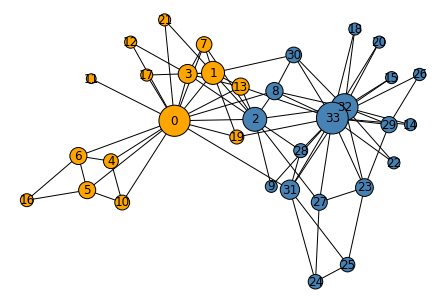

In [66]:
nx.draw(G, layout,
        with_labels=True, 
        node_color = colors,
        node_size  = [10000*PR[i] for i in G.nodes()],
        edgecolors = "black")

The resulting clusters are fairly similar to the "real" clusters observed in the fracturing of the club. However, fundamentally, graph clustering is an *unsupervised* machine learning task, which means that the problem of defining what makes a "good" set of clusters is quite subtle and depends strongly on the data domain. 